# Initialization

In [1]:
from fnmatch import filter
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, dates
import numpy as np
import datetime as dt
import spacepy.pycdf as cdf
import spacepy.toolbox as tb
import bisect as bi
import seaborn as sns
import os
from matplotlib.colors import LogNorm
from scipy.signal import kaiserord, filtfilt, firwin, freqz
from mpl_toolkits.axes_grid1 import make_axes_locatable
from Ross import *

In [2]:
sns.set_context('talk')
sns.set_style('ticks', rc={'axes.facecolor': 'k'})
sns.set_palette('muted', color_codes=True)
rc('text', usetex=True)
rc('font', family='Mono')
rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']

# Code

## Input

In [15]:
spe = 'H'
start = dt.datetime(2014, 9, 12, 21, 40)
stop = dt.datetime(2014, 9, 12, 22, 20)
craft = 'B'

## Processing

In [16]:
#Retrieve relevent data from RBSPICE (Particle Flux) and EMFISIS (Magnetic Field Magnitude)

if spe == 'H':
    sp = 'P'
else:
    sp = spe

Hpath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\TOFxE'+spe+'\\'
Hfname = filter(os.listdir(Hpath), '*'+start.strftime('%Y%m%d')+'*')[-1]

Hcdf = cdf.CDF(Hpath+Hfname)
epoch = Hcdf['Epoch'][...]
Flux = Hcdf['F'+sp+'DU'][...]
Energies = Hcdf['F'+sp+'DU_Energy'][...]
L = Hcdf['L'][...]
MLT = Hcdf['MLT'][...]
PAs = Hcdf['PA_Midpoint'][...]
PAs = (PAs-PAs[0])
PAs = PAs*(180/PAs[-1])
Hcdf.close()

Bpath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\EMFISIS'+'\\'
Bfname = filter(os.listdir(Bpath), '*'+start.strftime('%Y%m%d')+'*')[-1]

Bcdf = cdf.CDF(Bpath+Bfname)
Bepoch = Bcdf['Epoch'][...]
Bmag = Bcdf['Magnitude'][...]
Bcdf.close()

In [17]:
#Get array indices that match time window

fidx = bi.bisect_left(epoch, start)
fidx = int(fidx-(fidx/100))
lidx = bi.bisect_left(epoch, stop)
lidx = int(lidx+((len(epoch)-lidx)/100))

Bfidx = bi.bisect(Bepoch, start)
Bfidx = int(Bfidx-(Bfidx/100))
Blidx = bi.bisect(Bepoch, stop)
Blidx = int(Blidx+((len(Bepoch)-Blidx)/100))

In [18]:
#Use band-pass filter to allow only periods between minper and maxper, where resonance is evident
#A Kaiser window is used, kaiserord calculates beta parameter for window and optimal number of taps for filter
#Firwin calculates N taps (with N optimally calculated by kaiserord)
#filtfilt convolutes taps forward, and then backward to avoid data lag

Bnyq_rate = 0.5
Fnyq_rate = 0.05
Bwidth = 0.001/Bnyq_rate
Fwidth = 0.001/Fnyq_rate
ripple_db =50.0
minper = 120
maxper = 600
BN, Bbeta = kaiserord(ripple_db, Bwidth)
FN, Fbeta = kaiserord(ripple_db, Fwidth)

Bcutoff_hz = [(1/(maxper))/Bnyq_rate, (1/(minper))/Bnyq_rate]
Fcutoff_hz = [(1/(maxper))/Fnyq_rate, (1/(minper))/Fnyq_rate]

Btaps = firwin(BN, Bcutoff_hz, window=('kaiser', Bbeta), pass_zero=False)

Ftaps = firwin(FN, Fcutoff_hz, window=('kaiser', Fbeta), pass_zero=False)

Bwin = filtfilt(Btaps, 1.0, Bmag)

Fluxs = Flux
Fluxs[np.where(Fluxs<0)] = np.NaN

for i in range(len(Energies)):
    for j in range(len(PAs)):
        mask = np.isnan(Fluxs[:, i, j])
        Fluxs[mask, i, j] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), Fluxs[~mask, i, j])

Flux = filtfilt(Ftaps, 1.0, Fluxs, axis=0)

Flux = Flux.T
for i in range(len(PAs)):
    for j in range(len(Energies)):
        Flux[i, j] = tb.normalize(Flux[i, j])
Flux = Flux.T

## Plotting

In [19]:
#Plot filtered Magnetic flux density over filtered, normalized Flux to show resonance.
#Delete unused axes for asthetic reasons

plt.close('all')
fig, axs = plt.subplots(int(np.ceil(len(Energies)/2)), ncols=2, sharex=True, figsize=(15,10), gridspec_kw={'wspace':.4})
axs2=[]

for i, ax in enumerate(axs.T.flatten()):
    if i >= len(Energies):
        fig.delaxes(ax)
        axs = np.delete(axs, -1)
        break

    pax = ax.pcolormesh(dates.date2num(epoch[fidx:lidx]), PAs, Flux[fidx:lidx, i, :].T, cmap=plt.cm.jet, shading='gourad')
    
    ax.set_ylabel('%.2f keV' %(Energies[i]*1000))
    ax.set_yticks([0, 30, 60, 90, 120, 150, 180])
    
    axs2.append(ax.twinx())
    axs2[i].plot(dates.date2num(Bepoch[Bfidx:Blidx]), Bwin[Bfidx:Blidx],'w', lw=4)
    axs2[i].set_ylim(min(Bwin[Bfidx:Blidx]), max(Bwin[Bfidx:Blidx]))
    
    ax.set_xlim(start, stop)
    
axs = axs.flatten()
    
axs[0].set_ylabel('%.2f keV' %(Energies[0]*1000)+'\n'+r'$\boldsymbol{\alpha}\ (^{\boldsymbol{\circ}})$')
axs2[0].set_ylabel('B (nT)')

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    
cb = fig.colorbar(pax, cax=cbar_ax)
cb.set_label(r'Normalized counts sec$^{-1}$ ster$^{-1}$ cm$^{-2}$ keV$^{-1}$')
#Sets the colorbar value range
cb.set_clim(0, 1)
#Redraws the colorbar
cb.draw_all()

plt.setp(axs[-2].get_xticklabels(), visible=True)
plt.setp(axs[-1].get_xticklabels(), fontsize=15)
plt.setp(axs[-2].get_xticklabels(), fontsize=15)

if len(Energies)%2 == 1:
    multilabel(axs[-1], epoch, [epoch, L, MLT], titles=['Time', 'L (Re)', 'MLT'])
else:
    multilabel(axs[-2], epoch, [epoch, L, MLT], titles=['Time', 'L (Re)', 'MLT'])
    
for ax in axs[:2]:
    ax.tick_params(axis='x', top='off')

plt.subplots_adjust(left=0.1, right=0.89, top=0.95)

## End

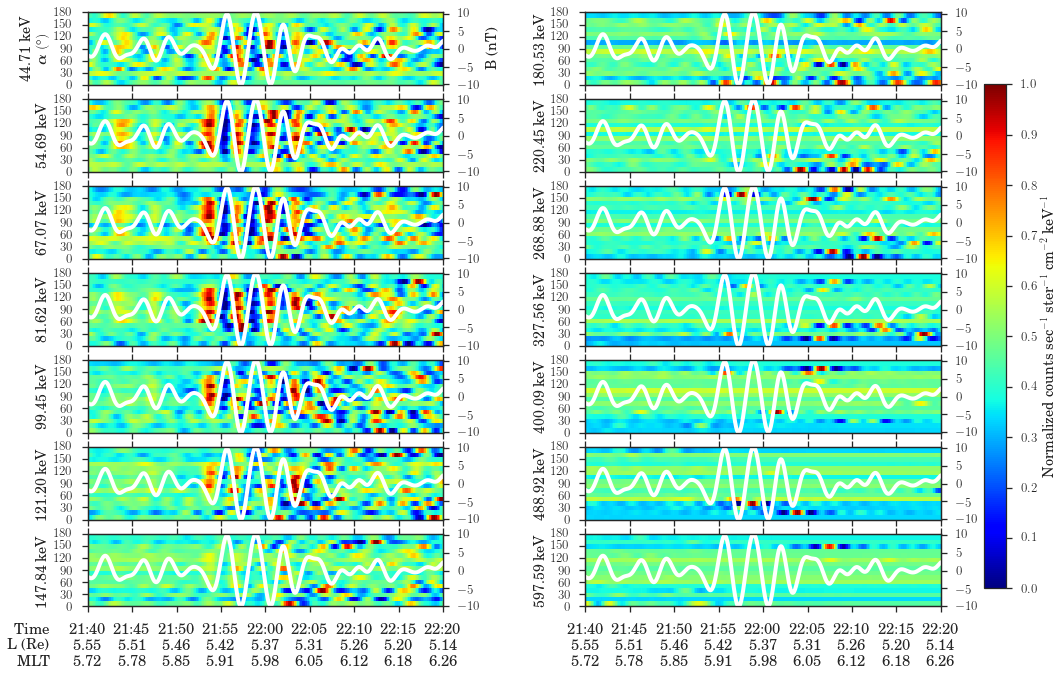

In [20]:
plt.show()
# plt.savefig('.\\specs\\'+craft+spe+start.strftime('%Y%m%d-%H%M-')+stop.strftime('%H%M-')+'PA.png', format='png', dpi=100)